In [229]:
from altaipony.lcio import from_mast, from_path
from altaipony.flarelc import FlareLightCurve
from altaipony.altai import find_iterative_median
from lightkurve import search_targetpixelfile

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import copy

def refine_detrended_flux_err(flcd, mask_pos_outliers_sigma=2.5, 
                              std_rolling_window_length=15, pad=25):
    """Attempt to recover a good estimate of the ligh curve noise.
    Start out from a simple standard deviation of the flux.
    Then filter out outliers above `mask_pos_outliers_sigma`.
    Apply rolling window standard deviation on the filtered array.
    Calculate a mean standard deviation from the result.
    Fill in this mean into the masked values.

    Parameters:
    -----------
    flcd : de-trended FlareLightCurve

    mask_pos_outliers_sigma : float
        sigma value above which to mask positive outliers
    std_rolling_window_length : int
        rolling window length for standard deviation calculation
    pad : int
        How many values to pad-mask around positive outliers.

    Return:
    --------
    FlareLightCurve with refined `detrended_flux_err` attribute.

    """

    # start with a first approximation to std
    flcd.detrended_flux_err[:] =  np.nanstd(flcd.detrended_flux)

    # and refine it:
    flcd = find_iterative_median(flcd)

    filtered = copy.deepcopy(flcd.detrended_flux)

    # mask strong positive outliers so that they don't add to std
    filtered[flcd.detrended_flux - flcd.it_med > mask_pos_outliers_sigma * flcd.detrended_flux_err] = np.nan

    # apply rolling window std
    flcd.detrended_flux_err[:] = pd.Series(filtered).rolling(std_rolling_window_length, min_periods=1).std()

    # set std to mean value if calculation fails to inf
    meanstd = np.nanmean(flcd.detrended_flux_err)

    # pad the excluded values not to create spikes of high error around flares
    isin = np.invert(np.isfinite(flcd.detrended_flux_err))
    x = np.where(isin)[0]
    for i in range(-pad, pad+1):
        y = x + i
        y[np.where(y > len(isin) - 1)] = len(isin) - 1
        isin[y] = True

    x = np.where(isin)[0]
    flcd.detrended_flux_err[x] = meanstd

    return flcd

import time

In [230]:
print("Ff")
time.sleep(10)
print("DD")

Ff
DD


In [12]:
df = pd.read_csv("../k2scoc/results/tables/custom_flares.csv",
                 names = ["ind","istart", "istop", 
                         "cstart", "cstop","tstart", "tstop",
                          "ed_rec", "ed_rec_err","ampl_rec","tot_dtp",
                          "EPIC", "C"
                         ])
df=df.drop_duplicates().sort_values(by="EPIC")
df.head()

,ind,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,tot_dtp,EPIC,C
448,1,2050,2056,109701.0,109707.0,2350.519115,2350.641705,58.354154,2.698376,0.008424,3446.0,200008704,5
447,0,320,324,107882.0,107887.0,2313.353658,2313.455819,28.719540,2.143911,0.005060,3446.0,200008704,5
1827,3,89,92,154425.0,154428.0,3264.388332,3264.449638,406.164140,33.203978,0.080444,3645.0,200200386,16
1824,0,1,7,154332.0,154338.0,3262.487838,3262.610450,1071.574417,77.197147,0.137745,3645.0,200200386,16
1829,5,897,900,155308.0,155311.0,3282.432923,3282.494230,771.061515,110.033967,0.154732,3645.0,200200386,16


In [234]:
cepic = df.groupby(["EPIC","C"])[["EPIC","C"]].count().index
cepic = np.array(cepic).T
cepic = np.array([list(x) for x in cepic]).T
cepic

array([[200008704, 200200386, 200200419, ..., 248045685, 248170923,
        248199652],
       [        5,        16,        16, ...,        13,        13,
               13]])

In [232]:
np.where(cepic[0]==211396385)[0]
len(cepic.T)

2176

In [235]:
EPIC = 211063098




C = 18
subdf = df[(df.C==C) & (df.EPIC==EPIC) & (df.istop - df.istart > 2)]

In [1]:
for EPIC, C in cepic.T[1200:]:
    flc = from_path(f"../k2scoc/pony_k2sc_k2_llc_{EPIC}-c{C:02d}_kepler_v2_lc.fits",
                    mode="AltaiPony", mission="K2")
    flc = refine_detrended_flux_err(flc)
    flares = flc.find_flares().flares
    flares["EPIC"] = EPIC
    flares["C"] = C
    with open("../k2scoc/results/tables/improved_flares.csv", "a") as f:
        flares.to_csv(f, index=False, header=False)
    time.sleep(20)

NameError: name 'cepic' is not defined

In [183]:
flc = from_path(f"../k2scoc/pony_k2sc_k2_llc_{EPIC}-c{C:02d}_kepler_v2_lc.fits", mode="AltaiPony", mission="K2")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:139: ResourceWarning: unclosed file <_io.FileIO name='../k2scoc/pony_k2sc_k2_llc_200233473-c18_kepler_v2_lc.fits' mode='rb' closefd=True>
  return _from_path_AltaiPony(path)


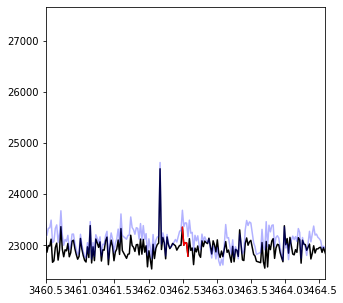

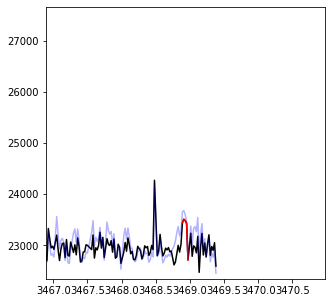

In [184]:

for i, r in subdf.iterrows():
    plt.figure(figsize=(5,5))
    plt.plot(flc.time, flc.detrended_flux,c="k")
    plt.plot(flc.time, flc.flux,c="b", alpha=.3)
    sta, sto = int(r.istart), int(r.istop)+1
    plt.plot(flc.time[sta:sto], flc.detrended_flux[sta:sto], c="r")
    plt.xlim(r.tstart-2,r.tstop+2)
    plt.ylim(np.min(1.*flc.detrended_flux),.92*np.max(flc.detrended_flux))

In [190]:
flc.detrended_flux_err
flc.detrended_flux.std(), refine_detrended_flux_err(flc).detrended_flux_err

(281.67079566473825,
 array([156.38496056, 156.38496056, 156.38496056, ..., 156.38496056,
        156.38496056, 156.38496056]))

In [42]:
flcd = flc.detrend("k2sc", de_niter=200, splits=[2344], ls_min_period=0.01)

Starting initial outlier detection at 3sigma.
iteration 1 at normalized median flux1.00000 \pm 0.02746
iteration 2 at normalized median flux1.00018 \pm 0.02724
iteration 3 at normalized median flux1.00021 \pm 0.02717
  Flagged 21 ( 0.6%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    0.22 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE


KeyboardInterrupt: 

In [17]:
flcd = flcd.find_flares()
flcd.flares

Found 169 candidate(s) in the (0,3446) gap.


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,total_n_valid_data_points
0,10,22,107562,107574,2306.815360,2307.060547,585.088512,0.512750,0.043903,3446.0
1,32,45,107584,107598,2307.264869,2307.550920,661.833381,0.539935,0.044891,3446.0
2,52,64,107605,107617,2307.693945,2307.939132,503.439324,0.503762,0.039421,3446.0
3,76,85,107629,107638,2308.184318,2308.368208,348.797139,0.457085,0.032541,3446.0
4,96,106,107650,107660,2308.613394,2308.817716,364.246756,0.466799,0.032909,3446.0
...,...,...,...,...,...,...,...,...,...,...
164,3346,3357,111107,111118,2379.246063,2379.470812,453.583124,0.499370,0.037712,3446.0
165,3366,3375,111128,111138,2379.675130,2379.879449,483.753684,0.501747,0.041714,3446.0
166,3386,3397,111150,111162,2380.124630,2380.369812,515.706867,0.498193,0.042083,3446.0
167,3406,3417,111171,111183,2380.553699,2380.798881,501.453647,0.538023,0.038111,3446.0


In [34]:
flcr = from_path(f"{ID}_5.fits", mode="AltaiPony", mission="K2")

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/altaipony-0.0.1-py3.6.egg/altaipony/lcio.py:139: ResourceWarning: unclosed file <_io.FileIO name='211412192_5.fits' mode='rb' closefd=True>
  return _from_path_AltaiPony(path)


In [ ]:
flcr2 = refine_detrended_flux_err(flcr)

(2320.0, 2345.0)

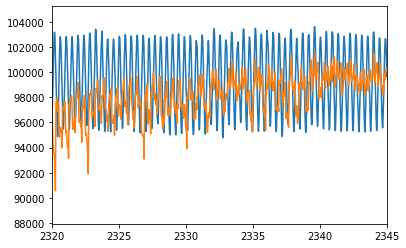

In [41]:
#plt.plot(flcr2.time, flcr2.detrended_flux_err,)
plt.plot(flcr.time, flcr.detrended_flux,)
plt.plot(flcd2.time, flcd2.detrended_flux,)
# plt.ylim(6250,6400)
plt.xlim(2320,2345)

In [43]:
flcd2 = copy.deepcopy(flcr)

flcd2 = custom_detrending(flcd2)

Remove fast rotation
18.263483878584477
18.263483878584477
18.263483878584477
8.168377220662817
8.168377220662817
9.11853766446924
9.11853766446924
9.280644157655795
9.280644157655795
3.7225228656195486
Remove rolling median.
Find iterative median.
Use savgol filter.
Determine improved uncertainty estimate.


(88000.0, 120000.0)

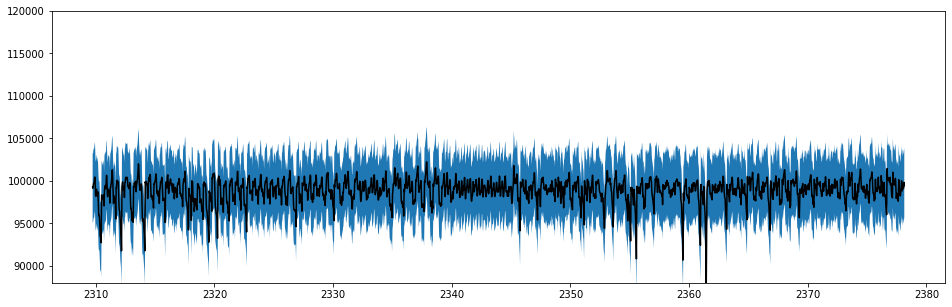

In [56]:
plt.figure(figsize=(16,5))
plt.plot(flcd2.time, flcd2.detrended_flux,c="k")
plt.fill_between(x=flcd2.time, y1=flcd2.detrended_flux-5*np.median(flcd2.detrended_flux_err),
                y2=flcd2.detrended_flux + 5*np.median(flcd2.detrended_flux_err))
#plt.xlim(2320,2325)
plt.ylim(88000,120000)

In [46]:
flcd2.detrended_flux_err

array([946.42705068, 946.42705068, 946.42705068, ..., 946.42705068,
       946.42705068, 946.42705068])

In [18]:
flcd.to_fits(f"{ID}_5.fits")

Did not save pixel_flux because fits files only accept 1D arrays.
Did not save pixel_flux_err because fits files only accept 1D arrays.
Did not save pipeline_mask because fits files only accept 1D arrays.


In [ ]:
plt.plot(flcd.time, flcd.detrended_flux)
#plt.xlim(3318, 3321)
#plt.xlim(3284, 3290)

In [ ]:
from astropy.io import fits

In [ ]:
hdu = fits.open("hlsp_k2sc_k2_llc_211398269-c05_kepler_v2_lc.fits")


In [ ]:
data = hdu[1].data
flck = FlareLightCurve(time=data.time, detrended_flux =data.flux)

In [ ]:
hdu[1].header

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(flck.time, flck.detrended_flux)

In [2]:
ID = 212009190
C=18
tpf = search_targetpixelfile("EPIC {}".format(ID), campaign=C).download()


Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/K2/ktwo212009190-c18_lc/ktwo212009190-c18_lpd-targ.fits.gz with expected size 2392157.
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


In [4]:

tpf.interact()


INFO:bokeh.server.server:Starting Bokeh server version 2.0.0 (running on Tornado 6.0.4)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


Uncaught exception GET /autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none (127.0.0.1)
HTTPServerRequest(protocol='http', host='localhost:42907', method='GET', uri='/autoload.js?bokeh-autoload-element=1005&bokeh-absolute-url=http://localhost:42907&resources=none', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/tornado/web.py", line 1703, in _execute
    result = await result
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/autoload_js_handler.py", line 60, in get
    session = await self.get_session()
  File "/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/bokeh/server/views/session_handler.py", line 120, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "/home/ekater

In [ ]:
# import seaborn as sns
# from matplotlib.colors import PowerNorm
# %matplotlib inline
# ras = tpf.get_coordinates(cadence=0)[0]
# decs = tpf.get_coordinates(cadence=0)[1]
# labels = np.chararray(ras.shape, itemsize=20, unicode=True)

# for i, row in enumerate(ras):
#     if i%5==0:
#         for j, col in enumerate(row):
#             if j%5 ==0:
#         #         l = "{:.4f}\n{:.4f}".format(col-tpf.ra, decs[i][j]-tpf.dec)
#                # l = "{:.4f}\n{:.4f}".format(col-92.154527, decs[i][j]-24.233511)
#                 l = "{:.03f}".format(100*np.sqrt((col-92.154527)**2+(decs[i][j]-24.233511)**2))
#                 labels[i][j] = l

# fig, ax = plt.subplots(figsize=(10,8))
# sns.heatmap(tpf.flux[0][:][::-1], annot = labels[:][::-1], fmt = '', ax=ax, cmap="viridis", norm=PowerNorm(gamma=1./2.))

In [ ]:
250./15000
